In [1]:
import sys

import meta_dataloader.TCGA

import numpy as np
import data.gene_graphs
import collections
import sklearn.metrics
import sklearn.model_selection
import random
from collections import OrderedDict
import pandas as pd
from torch.optim import Optimizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
%load_ext autoreload
%autoreload 2

In [2]:
tasks = meta_dataloader.TCGA.TCGAMeta(download=False, 
                                      min_samples_per_class=10)

546
326
545
326
546
326
546
326
524
315
544
326
541
323
109
64
421
246
420
246
226
31
408
248
191
18
190
19
334
211
268
229
488
289
466
283
495
277
264
219
191
18
191
18
187
27
1242
1215
1242
1215
1242
1215
1242
1215
1227
1200
1241
1214
1242
1215
1054
1026
872
872
893
893
968
948
873
873
900
881
845
845
747
747
1123
1098
1181
1155
1179
1154
956
956
802
802
791
791
791
791
785
785
782
782
781
781
776
776
697
697
49
49
47
47
34
34
204
196
204
196
204
196
204
196
204
196
204
196
181
175
192
186
69
67
70
68
70
68
127
121
70
68
201
193
161
155
105
101
92
79
92
79
92
79
92
79
92
79
92
79
78
66
90
77
87
74
79
70
70
61
68
60
48
48
25
25
48
48
48
48
47
47
48
48
27
27
48
48
42
42
80
80
80
80
80
80
80
80
80
80
80
80
48
48
53
53
80
80
80
80
78
78
80
80
566
550
566
550
566
550
566
550
565
549
566
550
273
272
522
507
454
447
566
550
484
473
200
173
199
172
185
160
194
169
192
168
161
161
187
172
196
170
173
173
200
173
197
171
192
168
187
172
436
426
436
426
436
426
436
426
432
422
433
423
430
421
4

/Users/Yuhan/src/CloserLookFewShot-customization/TCGAdata/meta_dataloader/TCGA.py:39: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(hdf_file)


In [3]:
print(len(tasks.task_ids))

174


In [10]:
clinical_variable_list = []
for taskid in sorted(tasks.task_ids):
    clinical_variable_list.append(taskid[0])
print(np.unique(clinical_variable_list))

['Expression_Subtype' 'GeneExp_Subtype' 'Metastasis_nature2012'
 'Node_nature2012' 'PAM50Call_RNAseq' '_EVENT' '_PANCAN_DNAMethyl_BLCA'
 '_PANCAN_DNAMethyl_BRCA' '_PANCAN_DNAMethyl_HNSC'
 '_PANCAN_DNAMethyl_LUAD' '_PANCAN_DNAMethyl_LUSC' '_PANCAN_mirna_BLCA'
 '_PANCAN_mirna_BRCA' '_PANCAN_mirna_HNSC' '_PANCAN_mirna_LAML'
 '_PANCAN_mirna_LUAD' '_PANCAN_mirna_LUSC' '_PANCAN_mirna_OV'
 'acute_myeloid_leukemia_calgb_cytogenetics_risk_category'
 'adjacent_hepatic_tissue_inflammation_extent_type'
 'alcohol_history_documented' 'anatomic_neoplasm_subdivision'
 'animal_insect_allergy_history' 'antireflux_treatment' 'asthma_history'
 'atypical_mitotic_figures' 'barretts_esophagus' 'biochemical_recurrence'
 'birth_control_pill_history_usage_category' 'clinical_M' 'clinical_stage'
 'colon_polyps_present' 'diabetes' 'family_history_of_cancer'
 'family_history_of_primary_brain_tumor'
 'family_history_of_stomach_cancer' 'family_history_other_cancer' 'gender'
 'histological_type' 'hypertension' 'icd_1

In [3]:
task = meta_dataloader.TCGA.TCGATask(('Expression_Subtype','LUNG'))
print(task.id)
print(task._samples.shape)
print(np.asarray(task._labels).shape)
print(collections.Counter(task._labels))

0              NaN
1       Bronchioid
2              NaN
3         Squamoid
4       Bronchioid
           ...    
1294           NaN
1295           NaN
1296           NaN
1297           NaN
1298           NaN
Name: Expression_Subtype, Length: 1299, dtype: object
0       False
1        True
2       False
3        True
4        True
        ...  
1294    False
1295    False
1296    False
1297    False
1298    False
Length: 1299, dtype: bool
275
{0: 'Bronchioid', 1: 'Magnoid', 2: 'Squamoid'}
['Bronchioid', 'Magnoid', 'Squamoid']
('Expression_Subtype', 'LUNG')
(275, 20530)
(275,)
Counter({0: 104, 2: 99, 1: 72})


In [25]:
for task in sorted(tasks):
    if task.id == ('gender', 'COAD'):
        print(task.id)
        print(task._samples.shape)
        print(np.asarray(task._labels).shape)
        print(len(collections.Counter(task._labels)))

0      FEMALE
1        MALE
2      FEMALE
3        MALE
4         NaN
        ...  
546    FEMALE
547      MALE
548    FEMALE
549      MALE
550    FEMALE
Name: gender, Length: 551, dtype: object
0       True
1       True
2       True
3       True
4      False
       ...  
546     True
547     True
548     True
549     True
550     True
Length: 551, dtype: bool
326
{0: 'FEMALE', 1: 'MALE'}
['FEMALE', 'MALE']
0      0.0
1      0.0
2      0.0
3      1.0
4      NaN
      ... 
546    0.0
547    0.0
548    0.0
549    0.0
550    0.0
Name: _EVENT, Length: 551, dtype: float64
0       True
1       True
2       True
3       True
4      False
       ...  
546     True
547     True
548     True
549     True
550     True
Length: 551, dtype: bool
315
{0: 0.0, 1: 1.0}
[0.0, 1.0]
0       NO
1       NO
2       NO
3      NaN
4      NaN
      ... 
546    NaN
547    NaN
548    YES
549     NO
550     NO
Name: lymphatic_invasion, Length: 551, dtype: object
0       True
1       True
2       True
3      False


0      1
1      1
2      1
3      1
4      1
      ..
199    0
200    0
201    0
202    0
203    1
Name: _EVENT, Length: 204, dtype: int64
0      True
1      True
2      True
3      True
4      True
       ... 
199    True
200    True
201    True
202    True
203    True
Length: 204, dtype: bool
196
{0: 0, 1: 1}
[0, 1]
0          Esophagus Adenocarcinoma, NOS
1          Esophagus Adenocarcinoma, NOS
2          Esophagus Adenocarcinoma, NOS
3          Esophagus Adenocarcinoma, NOS
4          Esophagus Adenocarcinoma, NOS
                     ...                
199    Esophagus Squamous Cell Carcinoma
200    Esophagus Squamous Cell Carcinoma
201    Esophagus Squamous Cell Carcinoma
202    Esophagus Squamous Cell Carcinoma
203        Esophagus Adenocarcinoma, NOS
Name: histological_type, Length: 204, dtype: object
0      True
1      True
2      True
3      True
4      True
       ... 
199    True
200    True
201    True
202    True
203    True
Length: 204, dtype: bool
196
{0: 'Esophagus A

0      True
1      True
2      True
3      True
4      True
       ... 
561    True
562    True
563    True
564    True
565    True
Name: oct_embedded, Length: 566, dtype: object
0      True
1      True
2      True
3      True
4      True
       ... 
561    True
562    True
563    True
564    True
565    True
Length: 566, dtype: bool
272
{0: False, 1: True}
[False, True]
0      NO
1      NO
2      NO
3      NO
4      NO
       ..
561    NO
562    NO
563    NO
564    NO
565    NO
Name: biochemical_recurrence, Length: 566, dtype: object
0      True
1      True
2      True
3      True
4      True
       ... 
561    True
562    True
563    True
564    True
565    True
Length: 566, dtype: bool
473
{0: 'NO', 1: 'YES'}
['NO', 'YES']
0        MALE
1      FEMALE
2        MALE
3        MALE
4        MALE
        ...  
195      MALE
196      MALE
197      MALE
198    FEMALE
199      MALE
Name: gender, Length: 200, dtype: object
0      False
1       True
2      False
3       True
4       True
    

0      YES
1      NaN
2       NO
3      NaN
4      NaN
      ... 
525     NO
526    YES
527     NO
528    YES
529    NaN
Name: family_history_of_cancer, Length: 530, dtype: object
0       True
1      False
2       True
3      False
4      False
       ...  
525     True
526     True
527     True
528     True
529    False
Length: 530, dtype: bool
356
{0: 'NO', 1: 'YES'}
['NO', 'YES']
0       NO
1       NO
2       NO
3      NaN
4      NaN
      ... 
525     NO
526     NO
527     NO
528     NO
529     NO
Name: asthma_history, Length: 530, dtype: object
0       True
1       True
2       True
3      False
4      False
       ...  
525     True
526     True
527     True
528     True
529     True
Length: 530, dtype: bool
375
{0: 'NO', 1: 'YES'}
['NO', 'YES']
0      YES
1      NaN
2       NO
3      NaN
4      NaN
      ... 
525     NO
526     NO
527     NO
528     NO
529     NO
Name: family_history_of_primary_brain_tumor, Length: 530, dtype: object
0       True
1      False
2       True
3     

0        MALE
1        MALE
2      FEMALE
3        MALE
4        MALE
        ...  
575      MALE
576      MALE
577      MALE
578      MALE
579    FEMALE
Name: gender, Length: 580, dtype: object
0      True
1      True
2      True
3      True
4      True
       ... 
575    True
576    True
577    True
578    True
579    True
Length: 580, dtype: bool
450
{0: 'FEMALE', 1: 'MALE'}
['FEMALE', 'MALE']
0      0.0
1      NaN
2      0.0
3      0.0
4      0.0
      ... 
575    1.0
576    0.0
577    1.0
578    0.0
579    1.0
Name: _EVENT, Length: 580, dtype: float64
0       True
1      False
2       True
3       True
4       True
       ...  
575     True
576     True
577     True
578     True
579     True
Length: 580, dtype: bool
421
{0: 0.0, 1: 1.0}
[0.0, 1.0]
0        NaN
1      False
2        NaN
3        NaN
4       True
       ...  
575     True
576      NaN
577     True
578    False
579     True
Name: oct_embedded, Length: 580, dtype: object
0      False
1       True
2      False
3      F

0       NO
1      NaN
2      NaN
3      NaN
4      YES
      ... 
191    YES
192    YES
193     NO
194    YES
195    NaN
Name: family_history_of_cancer, Length: 196, dtype: object
0       True
1      False
2      False
3      False
4       True
       ...  
191     True
192     True
193     True
194     True
195    False
Length: 196, dtype: bool
114
{0: 'NO', 1: 'YES'}
['NO', 'YES']
0      0.0
1      0.0
2      0.0
3      0.0
4      1.0
      ... 
591    1.0
592    0.0
593    0.0
594    0.0
595    0.0
Name: _EVENT, Length: 596, dtype: float64
0       True
1       True
2       True
3       True
4      False
       ...  
591     True
592     True
593     True
594     True
595     True
Length: 596, dtype: bool
188
{0: 0.0, 1: 1.0}
[0.0, 1.0]
0      Endometrioid endometrial adenocarcinoma
1      Endometrioid endometrial adenocarcinoma
2      Endometrioid endometrial adenocarcinoma
3      Endometrioid endometrial adenocarcinoma
4            Serous endometrial adenocarcinoma
                

0       NaN
1       0.0
2       1.0
3       0.0
4       0.0
       ... 
1294    1.0
1295    1.0
1296    NaN
1297    0.0
1298    1.0
Name: _EVENT, Length: 1299, dtype: float64
0       False
1        True
2        True
3        True
4        True
        ...  
1294     True
1295     True
1296    False
1297     True
1298     True
Length: 1299, dtype: bool
1109
{0: 0.0, 1: 1.0}
[0.0, 1.0]
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1294    True
1295    True
1296    True
1297    True
1298    True
Name: oct_embedded, Length: 1299, dtype: object
0       False
1       False
2       False
3       False
4       False
        ...  
1294     True
1295     True
1296    False
1297     True
1298     True
Length: 1299, dtype: bool
238
{0: False, 1: True}
[False, True]
0              NaN
1       Bronchioid
2              NaN
3         Squamoid
4       Bronchioid
           ...    
1294           NaN
1295           NaN
1296           NaN
1297           NaN
1298         

KeyboardInterrupt: 

In [4]:
def load_sets(task, valid=False):
     
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(task._samples, 
                                                                                task._labels, 
                                                                                stratify=task._labels,
                                                                                train_size=50,
                                                                                test_size=100,
                                                                                shuffle=True,
                                                                                random_state=0
                                                                                 )
    
    train_set = TensorDataset( Tensor(X_train), Tensor(y_train))
    test_set = TensorDataset( Tensor(X_test), Tensor(y_test))

    if valid:
        X_test, X_valid, y_test, y_valid = sklearn.model_selection.train_test_split(X_test, 
                                                                                y_test, 
                                                                                stratify=y_test,
                                                                                train_size=50,
                                                                                test_size=50,
                                                                                shuffle=True,
                                                                                random_state=0
                                                                               )
        valid_set = TensorDataset( Tensor(X_valid), Tensor(y_valid))
        return train_set, valid_set, test_set
        print(type(train_set))
    
    return train_set, test_set 

In [5]:
from sklearn.dummy import DummyClassifier
def Majority(X_train, X_test, y_train, y_test, random_state):
    
    classifier = DummyClassifier(strategy='most_frequent', random_state=random_state)
    classifier.fit(X_train, y_train)
    predicted = classifier.predict(X_test)
    accuracy = (predicted == y_test).mean()*100.
    return accuracy

In [6]:
class LogisticRegression(torch.nn.Module):
    
    def __init__(self, seed, input_size, num_classes, learning_rate, batch_size, epochs):
        super(LogisticRegression, self).__init__()
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.linear = torch.nn.Linear(input_size, num_classes)
        
        random.seed(seed)
        torch.manual_seed(seed)
    
    def forward(self, x, params=None):
        return self.linear(x)

    @property
    def criterion(self):
        return torch.nn.CrossEntropyLoss()
    
    @property
    def optimizer(self):
        return torch.optim.LBFGS(self.parameters(), lr=1)


In [7]:
def train(model, dataset, task_id, stop_early=False):
    train_loss = []
    criterion = model.criterion
    if type(model).__name__ == "LogisticRegression":
        optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=model.learning_rate, weight_decay= model.weight_decay)
     
    if stop_early:
        print("")
    else:
        train_set = dataset
        valid_set = None
 
    for i in range(model.epochs):
        for batch, labels in torch.utils.data.DataLoader(train_set, batch_size=model.batch_size, shuffle=True):
            labels = torch.autograd.Variable(labels.long())
            
            def closure():
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                out = model(batch)
                loss = criterion(out, labels)
                loss.backward()
                return loss
            
            intermediate = optimizer.step(closure)
            loss = intermediate.item()
            train_loss.append(loss)

    return model, loss

In [8]:
def test(model, test_set):
    # Test the Model
    batch, labels = next(iter(torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)))
    model.eval()
    outputs = model(batch)
    _, predicted = torch.max(outputs.data, 1)

    predicted = predicted.numpy()
    labels = labels.numpy()
    accuracy = (predicted == labels).mean()*100.
    return accuracy

# Logisitic Regression and Majority Experiments:

In [39]:
avg_maj_acc, avg_lr_acc = {}, {}
weight_decay = 0.05
batch_size = 32
epochs=8
for taskid in sorted(tasks.task_ids):
    task = meta_dataloader.TCGA.TCGATask(taskid)
    input_size = task._samples.shape[1]
    num_classes = len(collections.Counter(task._labels))
    for seed in [0,1,2,3,4,5,6,7,8,9,10]:
        try:
            X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(task._samples, 
                                                                                        task._labels, 
                                                                                        stratify=task._labels,
                                                                                        train_size=50,
                                                                                        test_size=100,
                                                                                        shuffle=True,
                                                                                        random_state=0
                                                                                         )
            train_set = TensorDataset( Tensor(X_train), Tensor(y_train))
            test_set = TensorDataset( Tensor(X_test), Tensor(y_test))

            #-----Majority-----
            mj_acc = Majority(X_train, X_test, y_train, y_test, seed)
            print("{} Majority Accuracy is: {}" .format(task.id, mj_acc))
            if task.id in avg_maj_acc.keys():
                avg_maj_acc[task.id].append(mj_acc)
            else:
                avg_maj_acc[task.id] = [mj_acc]

            #-----Logidtic Regression-----
            lr = 1.
            LR_model = LogisticRegression(seed, input_size, num_classes,lr, batch_size, epochs)
            trained_model, train_loss = train(LR_model, train_set, task.id, False)
            lr_result = test(trained_model, test_set)
            print("{} LR Accuracy is: {}" .format(task.id, lr_result))
            if task.id in avg_lr_acc.keys():
                avg_lr_acc[task.id].append(lr_result)
            else:
                avg_lr_acc[task.id] = [lr_result]

        except:
            print("Not enough samples!")

0             NaN
1      Bronchioid
2             NaN
3        Squamoid
4      Bronchioid
          ...    
701           NaN
702           NaN
703           NaN
704           NaN
705           NaN
Name: Expression_Subtype, Length: 706, dtype: object
0      False
1       True
2      False
3       True
4       True
       ...  
701    False
702    False
703    False
704    False
705    False
Length: 706, dtype: bool
275
{0: 'Bronchioid', 1: 'Magnoid', 2: 'Squamoid'}
['Bronchioid', 'Magnoid', 'Squamoid']
('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Accuracy is: 68.0
('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Accuracy is: 68.0
('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Accuracy is: 64.0
('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Accuracy is: 69.0
('Expression_Subtype', 'LUAD') Majority Accuracy is:

('Node_nature2012', 'BRCA') LR Accuracy is: 49.0
('Node_nature2012', 'BRCA') Majority Accuracy is: 49.0
('Node_nature2012', 'BRCA') LR Accuracy is: 51.0
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1242    NaN
1243    NaN
1244    NaN
1245    NaN
1246    NaN
Name: PAM50Call_RNAseq, Length: 1247, dtype: object
0       False
1       False
2       False
3       False
4       False
        ...  
1242    False
1243    False
1244    False
1245    False
1246    False
Length: 1247, dtype: bool
956
{0: 'Basal', 1: 'Her2', 2: 'LumA', 3: 'LumB', 4: 'Normal'}
['Basal', 'Her2', 'LumA', 'LumB', 'Normal']
('PAM50Call_RNAseq', 'BRCA') Majority Accuracy is: 45.0
('PAM50Call_RNAseq', 'BRCA') LR Accuracy is: 78.0
('PAM50Call_RNAseq', 'BRCA') Majority Accuracy is: 45.0
('PAM50Call_RNAseq', 'BRCA') LR Accuracy is: 76.0
('PAM50Call_RNAseq', 'BRCA') Majority Accuracy is: 45.0
('PAM50Call_RNAseq', 'BRCA') LR Accuracy is: 75.0
('PAM50Call_RNAseq', 'BRCA') Majority Accuracy is: 45.0
('

('_EVENT', 'COAD') LR Accuracy is: 70.0
('_EVENT', 'COAD') Majority Accuracy is: 75.0
('_EVENT', 'COAD') LR Accuracy is: 71.0
('_EVENT', 'COAD') Majority Accuracy is: 75.0
('_EVENT', 'COAD') LR Accuracy is: 73.0
('_EVENT', 'COAD') Majority Accuracy is: 75.0
('_EVENT', 'COAD') LR Accuracy is: 70.0
('_EVENT', 'COAD') Majority Accuracy is: 75.0
('_EVENT', 'COAD') LR Accuracy is: 60.0
('_EVENT', 'COAD') Majority Accuracy is: 75.0
('_EVENT', 'COAD') LR Accuracy is: 70.0
('_EVENT', 'COAD') Majority Accuracy is: 75.0
('_EVENT', 'COAD') LR Accuracy is: 73.0
('_EVENT', 'COAD') Majority Accuracy is: 75.0
('_EVENT', 'COAD') LR Accuracy is: 68.0
0      0.0
1      0.0
2      0.0
3      1.0
4      NaN
      ... 
731    0.0
732    0.0
733    0.0
734    0.0
735    0.0
Name: _EVENT, Length: 736, dtype: float64
0       True
1       True
2       True
3       True
4      False
       ...  
731     True
732     True
733     True
734     True
735     True
Length: 736, dtype: bool
418
{0: 0.0, 1: 1.0}
[0.0, 

('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 79.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 81.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 83.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 83.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 84.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 86.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 90.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 88.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 83.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 84.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 86.0
0      1.0
1      1.0
2      0.0
3      1.0
4      1.0

('_EVENT', 'LUSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'LUSC') LR Accuracy is: 51.0
('_EVENT', 'LUSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'LUSC') LR Accuracy is: 56.99999999999999
('_EVENT', 'LUSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'LUSC') LR Accuracy is: 54.0
('_EVENT', 'LUSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'LUSC') LR Accuracy is: 59.0
('_EVENT', 'LUSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'LUSC') LR Accuracy is: 51.0
('_EVENT', 'LUSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'LUSC') LR Accuracy is: 59.0
('_EVENT', 'LUSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'LUSC') LR Accuracy is: 51.0
('_EVENT', 'LUSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'LUSC') LR Accuracy is: 54.0
('_EVENT', 'LUSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'LUSC') LR Accuracy is: 52.0
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
82    0.0
83    0.0
84    0.0
85    

('_EVENT', 'STAD') LR Accuracy is: 49.0
('_EVENT', 'STAD') Majority Accuracy is: 61.0
('_EVENT', 'STAD') LR Accuracy is: 55.00000000000001
('_EVENT', 'STAD') Majority Accuracy is: 61.0
('_EVENT', 'STAD') LR Accuracy is: 61.0
('_EVENT', 'STAD') Majority Accuracy is: 61.0
('_EVENT', 'STAD') LR Accuracy is: 57.99999999999999
('_EVENT', 'STAD') Majority Accuracy is: 61.0
('_EVENT', 'STAD') LR Accuracy is: 51.0
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
575    0.0
576    0.0
577    0.0
578    0.0
579    0.0
Name: _EVENT, Length: 580, dtype: float64
0      True
1      True
2      True
3      True
4      True
       ... 
575    True
576    True
577    True
578    True
579    True
Length: 580, dtype: bool
571
{0: 0.0, 1: 1.0}
[0.0, 1.0]
('_EVENT', 'THCA') Majority Accuracy is: 97.0
('_EVENT', 'THCA') LR Accuracy is: 97.0
('_EVENT', 'THCA') Majority Accuracy is: 97.0
('_EVENT', 'THCA') LR Accuracy is: 96.0
('_EVENT', 'THCA') Majority Accuracy is: 97.0
('_EVENT', 'THCA') L

('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 68.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 16.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 49.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 72.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 72.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 64.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 59.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 54.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 67.0


('_PANCAN_mirna_HNSC', 'HNSC') LR Accuracy is: 49.0
('_PANCAN_mirna_HNSC', 'HNSC') Majority Accuracy is: 38.0
('_PANCAN_mirna_HNSC', 'HNSC') LR Accuracy is: 49.0
('_PANCAN_mirna_HNSC', 'HNSC') Majority Accuracy is: 38.0
('_PANCAN_mirna_HNSC', 'HNSC') LR Accuracy is: 17.0
('_PANCAN_mirna_HNSC', 'HNSC') Majority Accuracy is: 38.0
('_PANCAN_mirna_HNSC', 'HNSC') LR Accuracy is: 64.0
('_PANCAN_mirna_HNSC', 'HNSC') Majority Accuracy is: 38.0
('_PANCAN_mirna_HNSC', 'HNSC') LR Accuracy is: 53.0
('_PANCAN_mirna_HNSC', 'HNSC') Majority Accuracy is: 38.0
('_PANCAN_mirna_HNSC', 'HNSC') LR Accuracy is: 56.00000000000001
('_PANCAN_mirna_HNSC', 'HNSC') Majority Accuracy is: 38.0
('_PANCAN_mirna_HNSC', 'HNSC') LR Accuracy is: 47.0
('_PANCAN_mirna_HNSC', 'HNSC') Majority Accuracy is: 38.0
('_PANCAN_mirna_HNSC', 'HNSC') LR Accuracy is: 51.0
('_PANCAN_mirna_HNSC', 'HNSC') Majority Accuracy is: 38.0
('_PANCAN_mirna_HNSC', 'HNSC') LR Accuracy is: 46.0
0      cluster 3
1      cluster 5
2            NaN
3   

('acute_myeloid_leukemia_calgb_cytogenetics_risk_category', 'LAML') Majority Accuracy is: 60.0
('acute_myeloid_leukemia_calgb_cytogenetics_risk_category', 'LAML') LR Accuracy is: 79.0
('acute_myeloid_leukemia_calgb_cytogenetics_risk_category', 'LAML') Majority Accuracy is: 60.0
('acute_myeloid_leukemia_calgb_cytogenetics_risk_category', 'LAML') LR Accuracy is: 80.0
('acute_myeloid_leukemia_calgb_cytogenetics_risk_category', 'LAML') Majority Accuracy is: 60.0
('acute_myeloid_leukemia_calgb_cytogenetics_risk_category', 'LAML') LR Accuracy is: 65.0
('acute_myeloid_leukemia_calgb_cytogenetics_risk_category', 'LAML') Majority Accuracy is: 60.0
('acute_myeloid_leukemia_calgb_cytogenetics_risk_category', 'LAML') LR Accuracy is: 66.0
('acute_myeloid_leukemia_calgb_cytogenetics_risk_category', 'LAML') Majority Accuracy is: 60.0
('acute_myeloid_leukemia_calgb_cytogenetics_risk_category', 'LAML') LR Accuracy is: 19.0
('acute_myeloid_leukemia_calgb_cytogenetics_risk_category', 'LAML') Majority Acc

('alcohol_history_documented', 'PAAD') Majority Accuracy is: 61.0
('alcohol_history_documented', 'PAAD') LR Accuracy is: 53.0
('alcohol_history_documented', 'PAAD') Majority Accuracy is: 61.0
('alcohol_history_documented', 'PAAD') LR Accuracy is: 49.0
('alcohol_history_documented', 'PAAD') Majority Accuracy is: 61.0
('alcohol_history_documented', 'PAAD') LR Accuracy is: 53.0
('alcohol_history_documented', 'PAAD') Majority Accuracy is: 61.0
('alcohol_history_documented', 'PAAD') LR Accuracy is: 55.00000000000001
('alcohol_history_documented', 'PAAD') Majority Accuracy is: 61.0
('alcohol_history_documented', 'PAAD') LR Accuracy is: 59.0
('alcohol_history_documented', 'PAAD') Majority Accuracy is: 61.0
('alcohol_history_documented', 'PAAD') LR Accuracy is: 56.99999999999999
('alcohol_history_documented', 'PAAD') Majority Accuracy is: 61.0
('alcohol_history_documented', 'PAAD') LR Accuracy is: 54.0
('alcohol_history_documented', 'PAAD') Majority Accuracy is: 61.0
('alcohol_history_document

('animal_insect_allergy_history', 'LGG') LR Accuracy is: 83.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 93.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 85.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 87.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 89.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 87.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 85.0
0      NaN
1      NaN
2      NaN
3      NaN
4      YES
      ... 
575     NO
576     NO
577     NO
578    YES
579    YES
Name: antireflux_treatment, Length: 5

('biochemical_recurrence', 'PRAD') Majority Accuracy is: 87.0
('biochemical_recurrence', 'PRAD') LR Accuracy is: 82.0
('biochemical_recurrence', 'PRAD') Majority Accuracy is: 87.0
('biochemical_recurrence', 'PRAD') LR Accuracy is: 85.0
('biochemical_recurrence', 'PRAD') Majority Accuracy is: 87.0
('biochemical_recurrence', 'PRAD') LR Accuracy is: 73.0
('biochemical_recurrence', 'PRAD') Majority Accuracy is: 87.0
('biochemical_recurrence', 'PRAD') LR Accuracy is: 70.0
('biochemical_recurrence', 'PRAD') Majority Accuracy is: 87.0
('biochemical_recurrence', 'PRAD') LR Accuracy is: 82.0
('biochemical_recurrence', 'PRAD') Majority Accuracy is: 87.0
('biochemical_recurrence', 'PRAD') LR Accuracy is: 79.0
('biochemical_recurrence', 'PRAD') Majority Accuracy is: 87.0
('biochemical_recurrence', 'PRAD') LR Accuracy is: 80.0
('biochemical_recurrence', 'PRAD') Majority Accuracy is: 87.0
('biochemical_recurrence', 'PRAD') LR Accuracy is: 82.0
('biochemical_recurrence', 'PRAD') Majority Accuracy is:

('clinical_stage', 'KIRP') LR Accuracy is: 65.0
('clinical_stage', 'KIRP') Majority Accuracy is: 66.0
('clinical_stage', 'KIRP') LR Accuracy is: 55.00000000000001
('clinical_stage', 'KIRP') Majority Accuracy is: 66.0
('clinical_stage', 'KIRP') LR Accuracy is: 64.0
('clinical_stage', 'KIRP') Majority Accuracy is: 66.0
('clinical_stage', 'KIRP') LR Accuracy is: 64.0
('clinical_stage', 'KIRP') Majority Accuracy is: 66.0
('clinical_stage', 'KIRP') LR Accuracy is: 57.99999999999999
0      YES
1      YES
2       NO
3      YES
4      NaN
      ... 
546    NaN
547     NO
548     NO
549     NO
550     NO
Name: colon_polyps_present, Length: 551, dtype: object
0       True
1       True
2       True
3       True
4      False
       ...  
546    False
547     True
548     True
549     True
550     True
Length: 551, dtype: bool
219
{0: 'NO', 1: 'YES'}
['NO', 'YES']
('colon_polyps_present', 'COAD') Majority Accuracy is: 66.0
('colon_polyps_present', 'COAD') LR Accuracy is: 64.0
('colon_polyps_present

('family_history_of_cancer', 'LGG') LR Accuracy is: 52.0
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 53.0
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 46.0
0       NO
1      NaN
2      NaN
3      NaN
4      YES
      ... 
191    YES
192    YES
193     NO
194    YES
195    NaN
Name: family_history_of_cancer, Length: 196, dtype: object
0       True
1      False
2      False
3      False
4       True
       ...  
191     True
192     True
193     True
194     True
195    False
Length: 196, dtype: bool
114
{0: 'NO', 1: 'YES'}
['NO', 'YES']
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1143     NO
1144     NO
1

('gender', 'BLCA') Majority Accuracy is: 73.0
('gender', 'BLCA') LR Accuracy is: 79.0
('gender', 'BLCA') Majority Accuracy is: 73.0
('gender', 'BLCA') LR Accuracy is: 80.0
('gender', 'BLCA') Majority Accuracy is: 73.0
('gender', 'BLCA') LR Accuracy is: 78.0
('gender', 'BLCA') Majority Accuracy is: 73.0
('gender', 'BLCA') LR Accuracy is: 76.0
('gender', 'BLCA') Majority Accuracy is: 73.0
('gender', 'BLCA') LR Accuracy is: 82.0
('gender', 'BLCA') Majority Accuracy is: 73.0
('gender', 'BLCA') LR Accuracy is: 79.0
('gender', 'BLCA') Majority Accuracy is: 73.0
('gender', 'BLCA') LR Accuracy is: 78.0
('gender', 'BLCA') Majority Accuracy is: 73.0
('gender', 'BLCA') LR Accuracy is: 78.0
('gender', 'BLCA') Majority Accuracy is: 73.0
('gender', 'BLCA') LR Accuracy is: 82.0
('gender', 'BLCA') Majority Accuracy is: 73.0
('gender', 'BLCA') LR Accuracy is: 80.0
('gender', 'BLCA') Majority Accuracy is: 73.0
('gender', 'BLCA') LR Accuracy is: 82.0
0       FEMALE
1       FEMALE
2       FEMALE
3       F

('gender', 'ESCA') Majority Accuracy is: 84.0
('gender', 'ESCA') LR Accuracy is: 81.0
('gender', 'ESCA') Majority Accuracy is: 84.0
('gender', 'ESCA') LR Accuracy is: 84.0
('gender', 'ESCA') Majority Accuracy is: 84.0
('gender', 'ESCA') LR Accuracy is: 85.0
('gender', 'ESCA') Majority Accuracy is: 84.0
('gender', 'ESCA') LR Accuracy is: 85.0
('gender', 'ESCA') Majority Accuracy is: 84.0
('gender', 'ESCA') LR Accuracy is: 82.0
('gender', 'ESCA') Majority Accuracy is: 84.0
('gender', 'ESCA') LR Accuracy is: 85.0
('gender', 'ESCA') Majority Accuracy is: 84.0
('gender', 'ESCA') LR Accuracy is: 86.0
('gender', 'ESCA') Majority Accuracy is: 84.0
('gender', 'ESCA') LR Accuracy is: 85.0
('gender', 'ESCA') Majority Accuracy is: 84.0
('gender', 'ESCA') LR Accuracy is: 86.0
('gender', 'ESCA') Majority Accuracy is: 84.0
('gender', 'ESCA') LR Accuracy is: 84.0
('gender', 'ESCA') Majority Accuracy is: 84.0
('gender', 'ESCA') LR Accuracy is: 84.0
0      FEMALE
1         NaN
2        MALE
3        MAL

('gender', 'LAML') LR Accuracy is: 92.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 90.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 46.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 85.0
0      FEMALE
1        MALE
2      FEMALE
3        MALE
4        MALE
        ...  
525      MALE
526      MALE
527      MALE
528      MALE
529    FEMALE
Name: gender, Length: 530, dtype: object
0      True
1      True
2      True
3      True
4      True
       ... 
525    True
526    True
527    True
528    True
529    True
Length: 530, dtype: bool
529
{0: 'FEMALE', 1: 'MALE'}
['FEMALE', 'MALE']
('gender', 'LGG') Majority Accuracy is: 55.00000000000001
('gender', 'LGG') LR Accuracy is: 81.0
('gender', 'LGG') Majority Accuracy is: 55.00000000000001
('gender', 'LGG') LR Accuracy is: 79.0
('gender', 'LGG') Majority Accuracy is: 55.00000000000001
('gender', 'LGG') LR Accuracy is: 84.0
('gender', 

('gender', 'PAAD') LR Accuracy is: 93.0
('gender', 'PAAD') Majority Accuracy is: 55.00000000000001
('gender', 'PAAD') LR Accuracy is: 97.0
('gender', 'PAAD') Majority Accuracy is: 55.00000000000001
('gender', 'PAAD') LR Accuracy is: 92.0
('gender', 'PAAD') Majority Accuracy is: 55.00000000000001
('gender', 'PAAD') LR Accuracy is: 88.0
('gender', 'PAAD') Majority Accuracy is: 55.00000000000001
('gender', 'PAAD') LR Accuracy is: 89.0
('gender', 'PAAD') Majority Accuracy is: 55.00000000000001
('gender', 'PAAD') LR Accuracy is: 96.0
('gender', 'PAAD') Majority Accuracy is: 55.00000000000001
('gender', 'PAAD') LR Accuracy is: 86.0
('gender', 'PAAD') Majority Accuracy is: 55.00000000000001
('gender', 'PAAD') LR Accuracy is: 97.0
('gender', 'PAAD') Majority Accuracy is: 55.00000000000001
('gender', 'PAAD') LR Accuracy is: 91.0
('gender', 'PAAD') Majority Accuracy is: 55.00000000000001
('gender', 'PAAD') LR Accuracy is: 96.0
0      FEMALE
1      FEMALE
2      FEMALE
3        MALE
4        MALE

('gender', 'THCA') LR Accuracy is: 90.0
('gender', 'THCA') Majority Accuracy is: 73.0
('gender', 'THCA') LR Accuracy is: 89.0
('gender', 'THCA') Majority Accuracy is: 73.0
('gender', 'THCA') LR Accuracy is: 81.0
('gender', 'THCA') Majority Accuracy is: 73.0
('gender', 'THCA') LR Accuracy is: 87.0
('gender', 'THCA') Majority Accuracy is: 73.0
('gender', 'THCA') LR Accuracy is: 93.0
0        MALE
1        MALE
2        MALE
3        MALE
4      FEMALE
        ...  
121      MALE
122    FEMALE
123      MALE
124      MALE
125    FEMALE
Name: gender, Length: 126, dtype: object
0      True
1      True
2      True
3      True
4      True
       ... 
121    True
122    True
123    True
124    True
125    True
Length: 126, dtype: bool
122
{0: 'FEMALE', 1: 'MALE'}
['FEMALE', 'MALE']
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough sampl

('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 95.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD'

Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
0       NO
1      YES
2      YES
3       NO
4       NO
      ... 
591     NO
592    YES
593    YES
594    YES
595    YES
Name: hypertension, Length: 596, dtype: object
0       True
1       True
2       True
3       True
4      False
       ...  
591     True
592     True
593     True
594     True
595     True
Length: 596, dtype: bool
143
{0: 'NO', 1: 'YES'}
['NO', 'YES']
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
0      NO
1      NO
2     YES
3      NO
4     YES
5     YES
6      NO
7     YES
8      NO
9     NaN
10     NO
11     NO
12    YES
13     NO
14    YES
15    YES
16    YES
17     NO
18    

Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
0       NO
1      NaN
2      YES
3      YES
4       NO
      ... 
431    YES
432     NO
433    YES
434     NO
435    NaN
Name: lymphovascular_invasion_present, Length: 436, dtype: object
0       True
1      False
2       True
3       True
4       True
       ...  
431     True
432     True
433     True
434     True
435    False
Length: 436, dtype: bool
292
{0: 'NO', 1: 'YES'}
['NO', 'YES']
('lymphovascular_invasion_present', 'BLCA') Majority Accuracy is: 55.00000000000001
('lymphovascular_invasion_present', 'BLCA') LR Accuracy is: 51.0
('lymphovascular_invasion_present', 'BLCA') Majority Accuracy is: 55.00000000000001
('lymphovascular_invasion_present', 'BLCA') LR Accuracy is: 50.0
('lymphovascular_invasion_present', 'BLCA') Majority Accuracy is: 55.00000000000001
('lym

('mental_status_changes', 'GBMLGG') LR Accuracy is: 64.0
('mental_status_changes', 'GBMLGG') Majority Accuracy is: 75.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 65.0
('mental_status_changes', 'GBMLGG') Majority Accuracy is: 75.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 68.0
('mental_status_changes', 'GBMLGG') Majority Accuracy is: 75.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 64.0
('mental_status_changes', 'GBMLGG') Majority Accuracy is: 75.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 65.0
('mental_status_changes', 'GBMLGG') Majority Accuracy is: 75.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 70.0
('mental_status_changes', 'GBMLGG') Majority Accuracy is: 75.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 66.0
('mental_status_changes', 'GBMLGG') Majority Accuracy is: 75.0
('mental_status_changes', 'GBMLGG') LR Accuracy is: 66.0
0       NO
1      NaN
2      YES
3      NaN
4      YES
      ... 
525     NO
526     NO
527     NO
528 

('oct_embedded', 'BLCA') LR Accuracy is: 78.0
0        True
1        True
2         NaN
3        True
4        True
        ...  
1242    False
1243    False
1244    False
1245     True
1246     True
Name: oct_embedded, Length: 1247, dtype: object
0        True
1        True
2       False
3        True
4        True
        ...  
1242     True
1243    False
1244     True
1245     True
1246     True
Length: 1247, dtype: bool
1026
{0: False, 1: True}
[False, True]
('oct_embedded', 'BRCA') Majority Accuracy is: 62.0
('oct_embedded', 'BRCA') LR Accuracy is: 59.0
('oct_embedded', 'BRCA') Majority Accuracy is: 62.0
('oct_embedded', 'BRCA') LR Accuracy is: 56.99999999999999
('oct_embedded', 'BRCA') Majority Accuracy is: 62.0
('oct_embedded', 'BRCA') LR Accuracy is: 57.99999999999999
('oct_embedded', 'BRCA') Majority Accuracy is: 62.0
('oct_embedded', 'BRCA') LR Accuracy is: 57.99999999999999
('oct_embedded', 'BRCA') Majority Accuracy is: 62.0
('oct_embedded', 'BRCA') LR Accuracy is: 57.999999

('oct_embedded', 'KIRP') Majority Accuracy is: 59.0
('oct_embedded', 'KIRP') LR Accuracy is: 57.99999999999999
('oct_embedded', 'KIRP') Majority Accuracy is: 59.0
('oct_embedded', 'KIRP') LR Accuracy is: 57.99999999999999
('oct_embedded', 'KIRP') Majority Accuracy is: 59.0
('oct_embedded', 'KIRP') LR Accuracy is: 61.0
('oct_embedded', 'KIRP') Majority Accuracy is: 59.0
('oct_embedded', 'KIRP') LR Accuracy is: 59.0
('oct_embedded', 'KIRP') Majority Accuracy is: 59.0
('oct_embedded', 'KIRP') LR Accuracy is: 60.0
('oct_embedded', 'KIRP') Majority Accuracy is: 59.0
('oct_embedded', 'KIRP') LR Accuracy is: 57.99999999999999
('oct_embedded', 'KIRP') Majority Accuracy is: 59.0
('oct_embedded', 'KIRP') LR Accuracy is: 52.0
('oct_embedded', 'KIRP') Majority Accuracy is: 59.0
('oct_embedded', 'KIRP') LR Accuracy is: 61.0
('oct_embedded', 'KIRP') Majority Accuracy is: 59.0
('oct_embedded', 'KIRP') LR Accuracy is: 60.0
('oct_embedded', 'KIRP') Majority Accuracy is: 59.0
('oct_embedded', 'KIRP') LR

Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
0      True
1      True
2      True
3      True
4      True
       ... 
561    True
562    True
563    True
564    True
565    True
Name: oct_embedded, Length: 566, dtype: object
0      True
1      True
2      True
3      True
4      True
       ... 
561    True
562    True
563    True
564    True
565    True
Length: 566, dtype: bool
272
{0: False, 1: True}
[False, True]
('oct_embedded', 'PRAD') Majority Accuracy is: 89.0
('oct_embedded', 'PRAD') LR Accuracy is: 75.0
('oct_embedded', 'PRAD') Majority Accuracy is: 89.0
('oct_embedded', 'PRAD') LR Accuracy is: 72.0
('oct_embedded', 'PRAD') Majority Accuracy is: 89.0
('oct_embedded', 'PRAD') LR Accuracy is: 80.0
('oct_embedded', 'PRAD') Majority Accuracy is: 89.0
('oct_embedded', 'PRAD') LR Accuracy is: 74.0
('oct_embedded

('oct_embedded', 'THCA') LR Accuracy is: 62.0
0      False
1      False
2      False
3      False
4      False
       ...  
121     True
122     True
123     True
124     True
125    False
Name: oct_embedded, Length: 126, dtype: object
0      True
1      True
2      True
3      True
4      True
       ... 
121    True
122    True
123    True
124    True
125    True
Length: 126, dtype: bool
114
{0: False, 1: True}
[False, True]
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
0      False
1      False
2      False
3       True
4       True
       ...  
591    False
592    False
593    False
594     True
595     True
Name: oct_embedded, Length: 596, dtype: object
0       True
1       True
2       True
3       True
4      False
       ...  
591     True
592     True
593     True
594     True
595     True
Length: 596, dty

('synchronous_colon_cancer_present', 'COADREAD') LR Accuracy is: 96.0
0      Colon
1      Colon
2      Colon
3      Colon
4        NaN
       ...  
731    Colon
732    Colon
733    Colon
734    Colon
735    Colon
Name: tumor_tissue_site, Length: 736, dtype: object
0       True
1       True
2       True
3       True
4      False
       ...  
731     True
732     True
733     True
734     True
735     True
Length: 736, dtype: bool
427
{0: 'Colon', 1: 'Rectum'}
['Colon', 'Rectum']
('tumor_tissue_site', 'COADREAD') Majority Accuracy is: 76.0
('tumor_tissue_site', 'COADREAD') LR Accuracy is: 73.0
('tumor_tissue_site', 'COADREAD') Majority Accuracy is: 76.0
('tumor_tissue_site', 'COADREAD') LR Accuracy is: 67.0
('tumor_tissue_site', 'COADREAD') Majority Accuracy is: 76.0
('tumor_tissue_site', 'COADREAD') LR Accuracy is: 75.0
('tumor_tissue_site', 'COADREAD') Majority Accuracy is: 76.0
('tumor_tissue_site', 'COADREAD') LR Accuracy is: 41.0
('tumor_tissue_site', 'COADREAD') Majority Accuracy i

('venous_invasion', 'COADREAD') LR Accuracy is: 75.0
('venous_invasion', 'COADREAD') Majority Accuracy is: 77.0
('venous_invasion', 'COADREAD') LR Accuracy is: 72.0
('venous_invasion', 'COADREAD') Majority Accuracy is: 77.0
('venous_invasion', 'COADREAD') LR Accuracy is: 72.0
('venous_invasion', 'COADREAD') Majority Accuracy is: 77.0
('venous_invasion', 'COADREAD') LR Accuracy is: 75.0
('venous_invasion', 'COADREAD') Majority Accuracy is: 77.0
('venous_invasion', 'COADREAD') LR Accuracy is: 78.0
('venous_invasion', 'COADREAD') Majority Accuracy is: 77.0
('venous_invasion', 'COADREAD') LR Accuracy is: 70.0
('venous_invasion', 'COADREAD') Majority Accuracy is: 77.0
('venous_invasion', 'COADREAD') LR Accuracy is: 74.0
('venous_invasion', 'COADREAD') Majority Accuracy is: 77.0
('venous_invasion', 'COADREAD') LR Accuracy is: 78.0
('venous_invasion', 'COADREAD') Majority Accuracy is: 77.0
('venous_invasion', 'COADREAD') LR Accuracy is: 76.0
('venous_invasion', 'COADREAD') Majority Accuracy i

In [202]:
print(avg_maj_acc)

{('Expression_Subtype', 'LUAD'): [38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0], ('Expression_Subtype', 'LUNG'): [38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0], ('GeneExp_Subtype', 'GBM'): [33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0], ('Metastasis_nature2012', 'BRCA'): [98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0], ('Node_nature2012', 'BRCA'): [49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0], ('PAM50Call_RNAseq', 'BRCA'): [45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0], ('_EVENT', 'BLCA'): [55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001], ('_EVENT', 'BRCA'): [83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0], ('_EVENT', 'CESC'): [75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0]

In [203]:
print(avg_lr_acc)

{('Expression_Subtype', 'LUAD'): [62.0, 56.99999999999999, 64.0, 57.99999999999999, 69.0, 38.0, 61.0, 67.0, 60.0, 70.0, 61.0], ('Expression_Subtype', 'LUNG'): [62.0, 56.99999999999999, 64.0, 57.99999999999999, 69.0, 38.0, 61.0, 67.0, 60.0, 70.0, 61.0], ('GeneExp_Subtype', 'GBM'): [68.0, 25.0, 69.0, 64.0, 65.0, 70.0, 66.0, 51.0, 72.0, 68.0, 68.0], ('Metastasis_nature2012', 'BRCA'): [98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0], ('Node_nature2012', 'BRCA'): [34.0, 40.0, 42.0, 45.0, 32.0, 42.0, 50.0, 42.0, 42.0, 42.0, 39.0], ('PAM50Call_RNAseq', 'BRCA'): [79.0, 74.0, 77.0, 15.0, 77.0, 73.0, 70.0, 68.0, 69.0, 78.0, 79.0], ('_EVENT', 'BLCA'): [59.0, 54.0, 59.0, 56.00000000000001, 55.00000000000001, 54.0, 56.99999999999999, 51.0, 51.0, 56.00000000000001, 57.99999999999999], ('_EVENT', 'BRCA'): [77.0, 77.0, 81.0, 61.0, 77.0, 72.0, 80.0, 81.0, 81.0, 73.0, 70.0], ('_EVENT', 'CESC'): [75.0, 72.0, 71.0, 69.0, 60.0, 69.0, 75.0, 67.0, 68.0, 68.0, 61.0], ('_EVENT', 'COAD'): [71.

In [257]:
print(np.std(avg_lr_acc[('white_cell_count_result', 'KIRP')]))
print(np.std(avg_maj_acc[('white_cell_count_result', 'KIRP')]))

5.1666444503210265
0.0


In [252]:
def measure_mean_std(model_dict):
    mean_std_results = {}
    for task in model_dict.keys():
        mean = np.mean(model_dict[task])
        std =  np.std(model_dict[task])
        mean_std_results[task] = {'mean':mean,'std': std}
    return mean_std_results

In [260]:
Maj_dict = measure_mean_std(avg_maj_acc)

In [299]:
import os
path = '/Users/mandanasamiei/PycharmProjects/TCGA_Benchmark'
result_dataframe = pd.DataFrame.from_dict(Maj_dict, orient='index')
result_dataframe.to_csv(os.path.join(path,'Majority_result_10seeds.csv'))

In [302]:
print(Maj_dict)
print(len(Maj_dict))#121

{('Expression_Subtype', 'LUAD'): {'mean': 38.0, 'std': 0.0}, ('Expression_Subtype', 'LUNG'): {'mean': 38.0, 'std': 0.0}, ('GeneExp_Subtype', 'GBM'): {'mean': 33.0, 'std': 0.0}, ('Metastasis_nature2012', 'BRCA'): {'mean': 98.0, 'std': 0.0}, ('Node_nature2012', 'BRCA'): {'mean': 49.0, 'std': 0.0}, ('PAM50Call_RNAseq', 'BRCA'): {'mean': 45.0, 'std': 0.0}, ('_EVENT', 'BLCA'): {'mean': 55.00000000000001, 'std': 0.0}, ('_EVENT', 'BRCA'): {'mean': 83.0, 'std': 0.0}, ('_EVENT', 'CESC'): {'mean': 75.0, 'std': 0.0}, ('_EVENT', 'COAD'): {'mean': 75.0, 'std': 0.0}, ('_EVENT', 'COADREAD'): {'mean': 76.0, 'std': 0.0}, ('_EVENT', 'ESCA'): {'mean': 57.99999999999999, 'std': 0.0}, ('_EVENT', 'GBM'): {'mean': 77.0, 'std': 0.0}, ('_EVENT', 'GBMLGG'): {'mean': 62.0, 'std': 0.0}, ('_EVENT', 'HNSC'): {'mean': 55.00000000000001, 'std': 0.0}, ('_EVENT', 'KIRP'): {'mean': 84.0, 'std': 0.0}, ('_EVENT', 'LAML'): {'mean': 65.0, 'std': 0.0}, ('_EVENT', 'LGG'): {'mean': 75.0, 'std': 0.0}, ('_EVENT', 'LIHC'): {'mean

In [ ]:
print(np.unique(Maj_dict.keys()[1]))

In [263]:
LR_dict= measure_mean_std(avg_lr_acc)
print(LR_dict)

{('Expression_Subtype', 'LUAD'): {'mean': 60.63636363636363, 'std': 8.227147161271832}, ('Expression_Subtype', 'LUNG'): {'mean': 60.63636363636363, 'std': 8.227147161271832}, ('GeneExp_Subtype', 'GBM'): {'mean': 62.36363636363637, 'std': 12.928282788822674}, ('Metastasis_nature2012', 'BRCA'): {'mean': 98.0, 'std': 0.0}, ('Node_nature2012', 'BRCA'): {'mean': 40.90909090909091, 'std': 4.640817824763715}, ('PAM50Call_RNAseq', 'BRCA'): {'mean': 69.0, 'std': 17.49805183961398}, ('_EVENT', 'BLCA'): {'mean': 55.45454545454545, 'std': 2.675261630829483}, ('_EVENT', 'BRCA'): {'mean': 75.45454545454545, 'std': 5.852173432520393}, ('_EVENT', 'CESC'): {'mean': 68.63636363636364, 'std': 4.617609126981925}, ('_EVENT', 'COAD'): {'mean': 71.36363636363636, 'std': 2.568081253059188}, ('_EVENT', 'COADREAD'): {'mean': 65.36363636363636, 'std': 5.032128182944745}, ('_EVENT', 'ESCA'): {'mean': 54.54545454545455, 'std': 4.185768884807758}, ('_EVENT', 'GBM'): {'mean': 66.18181818181819, 'std': 3.785575057028

In [303]:
result_dataframe = pd.DataFrame.from_dict(LR_dict, orient='index')
result_dataframe.to_csv(os.path.join(path,'LogisticRegression_result_10seeds.csv'))

[38.0, 38.0, 33.0, 98.0, 49.0, 45.0, 55.00000000000001, 83.0, 75.0, 75.0, 76.0, 57.99999999999999, 77.0, 62.0, 55.00000000000001, 84.0, 65.0, 75.0, 61.0, 63.0, 59.0, 55.00000000000001, 60.0, 52.0, 63.0, 52.0, 61.0, 97.0, 81.0, 30.0, 41.0, 43.0, 38.0, 32.0, 38.0, 35.0, 31.0, 56.99999999999999, 28.000000000000004, 60.0, 52.0, 73.0, 67.0, 61.0, 73.0, 77.0, 95.0, 95.0, 79.0, 94.0, 94.0, 91.0, 87.0, 55.00000000000001, 75.0, 66.0, 66.0, 71.0, 62.0, 62.0, 96.0, 96.0, 95.0, 73.0, 99.0, 54.0, 54.0, 84.0, 65.0, 56.99999999999999, 73.0, 73.0, 54.0, 55.00000000000001, 66.0, 54.0, 60.0, 74.0, 55.00000000000001, 55.00000000000001, 55.00000000000001, 62.0, 65.0, 73.0, 49.0, 38.0, 82.0, 97.0, 62.0, 69.0, 69.0, 55.00000000000001, 64.0, 69.0, 75.0, 75.0, 67.0, 85.0, 62.0, 55.00000000000001, 57.99999999999999, 63.0, 51.0, 59.0, 60.0, 65.0, 69.0, 89.0, 85.0, 80.0, 60.0, 57.99999999999999, 65.0, 95.0, 96.0, 76.0, 76.0, 82.0, 77.0, 77.0, 74.0]


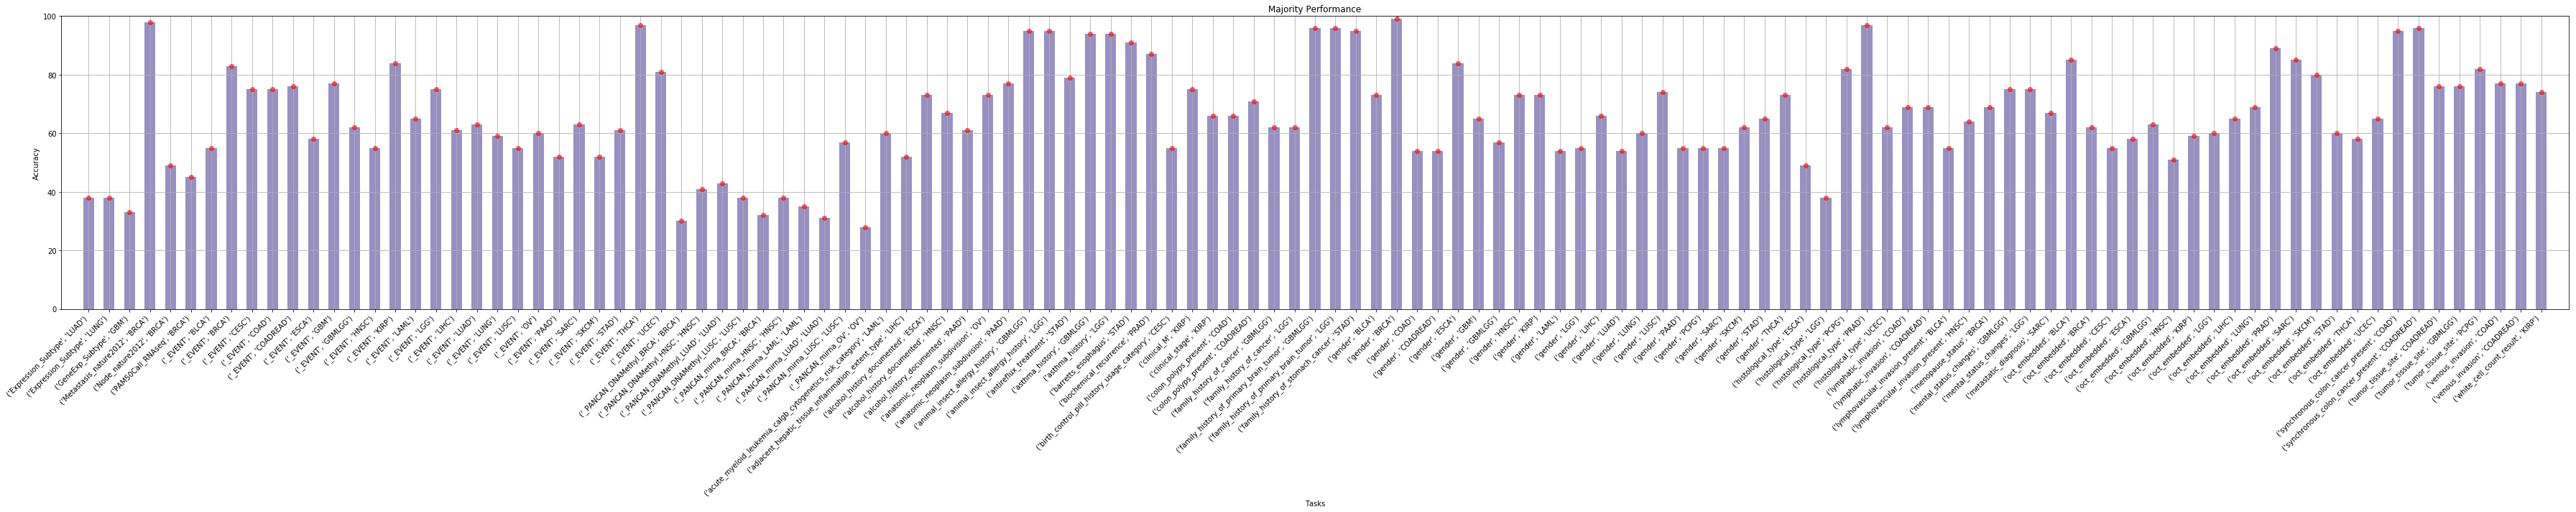

In [296]:
model_visualization(Maj_dict, list(Maj_dict.keys()), "Majority", color='#332288')

[60.63636363636363, 60.63636363636363, 62.36363636363637, 98.0, 40.90909090909091, 69.0, 55.45454545454545, 75.45454545454545, 68.63636363636364, 71.36363636363636, 65.36363636363636, 54.54545454545455, 66.18181818181819, 73.18181818181819, 57.09090909090909, 84.27272727272727, 52.72727272727273, 70.81818181818181, 57.81818181818182, 55.54545454545455, 58.18181818181818, 55.72727272727273, 54.45454545454545, 56.0, 54.81818181818182, 59.18181818181818, 56.90909090909091, 95.9090909090909, 78.54545454545455, 47.63636363636363, 62.36363636363637, 46.27272727272727, 52.63636363636363, 23.727272727272727, 51.90909090909091, 59.18181818181818, 33.81818181818182, 48.72727272727273, 26.818181818181817, 68.27272727272727, 52.54545454545455, 62.27272727272727, 65.36363636363636, 51.54545454545455, 64.18181818181819, 71.45454545454545, 89.9090909090909, 89.9090909090909, 75.63636363636364, 92.9090909090909, 92.9090909090909, 88.27272727272727, 81.81818181818181, 45.54545454545455, 68.818181818181

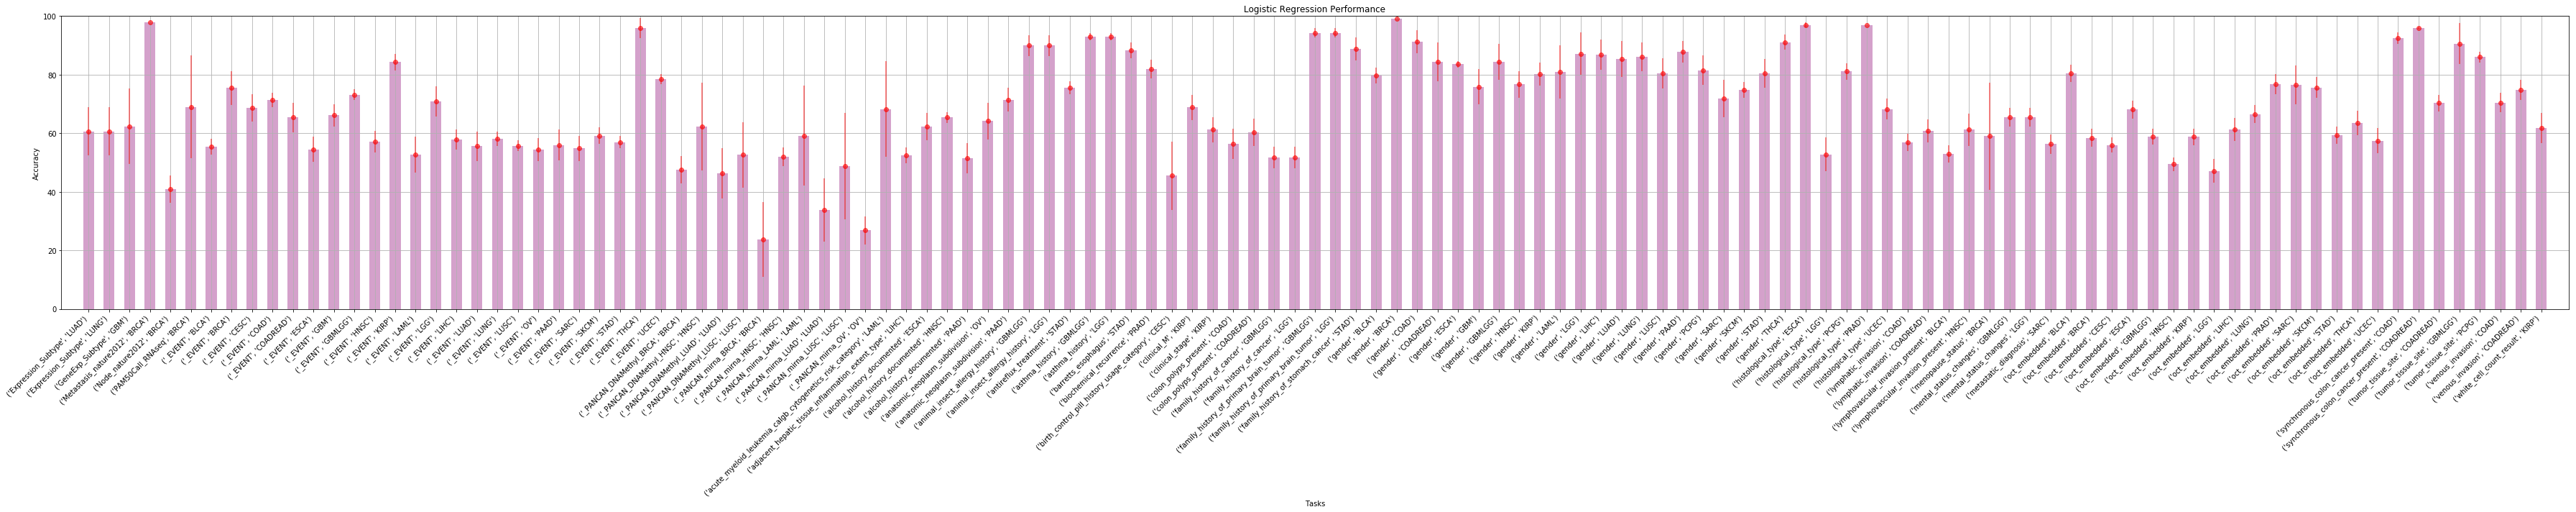

In [295]:
model_visualization(LR_dict, list(LR_dict.keys()), "Logistic Regression", '#AA4499')

In [363]:
import matplotlib.pyplot as plt
def model_visualization(model_dict, tasks, label="model_name", color='#332288'):
    means, stds = [], []
    for task in tasks:
        means.append(model_dict[task]['mean'])   
        stds.append(model_dict[task]['std'])
    print(means)
    width = 0.5 # the width of the bars
    colors = ['#332288', '#AA4499', '#44AA99']
    #flatten_std = [item for sublist in stds for item in sublist]
    x = np.arange(len(tasks))
    new_x = [1.5*i for i in x]
    fig, ax = plt.subplots(figsize=(50, 10))
    plt.bar(new_x, means, color=color, alpha=0.5)
    plt.xticks(new_x, tasks)
    plt.title("{} Performance".format(label))
    plt.ylabel('Accuracy')
    plt.xlabel('Tasks')
    ax.set_xticklabels(tasks, rotation=45, ha="right")
    plt.xlim(min(new_x) - 2, max(new_x) + 2)
    plt.ylim(0, 100)
    plt.grid()
    plt.errorbar(new_x, means, stds, linestyle='None', marker='o', color='r', alpha=0.6)
    fig.tight_layout()
    plt.show()

    #plt.savefig('/{}_result_plot_with_error_bars.png'.format(label))


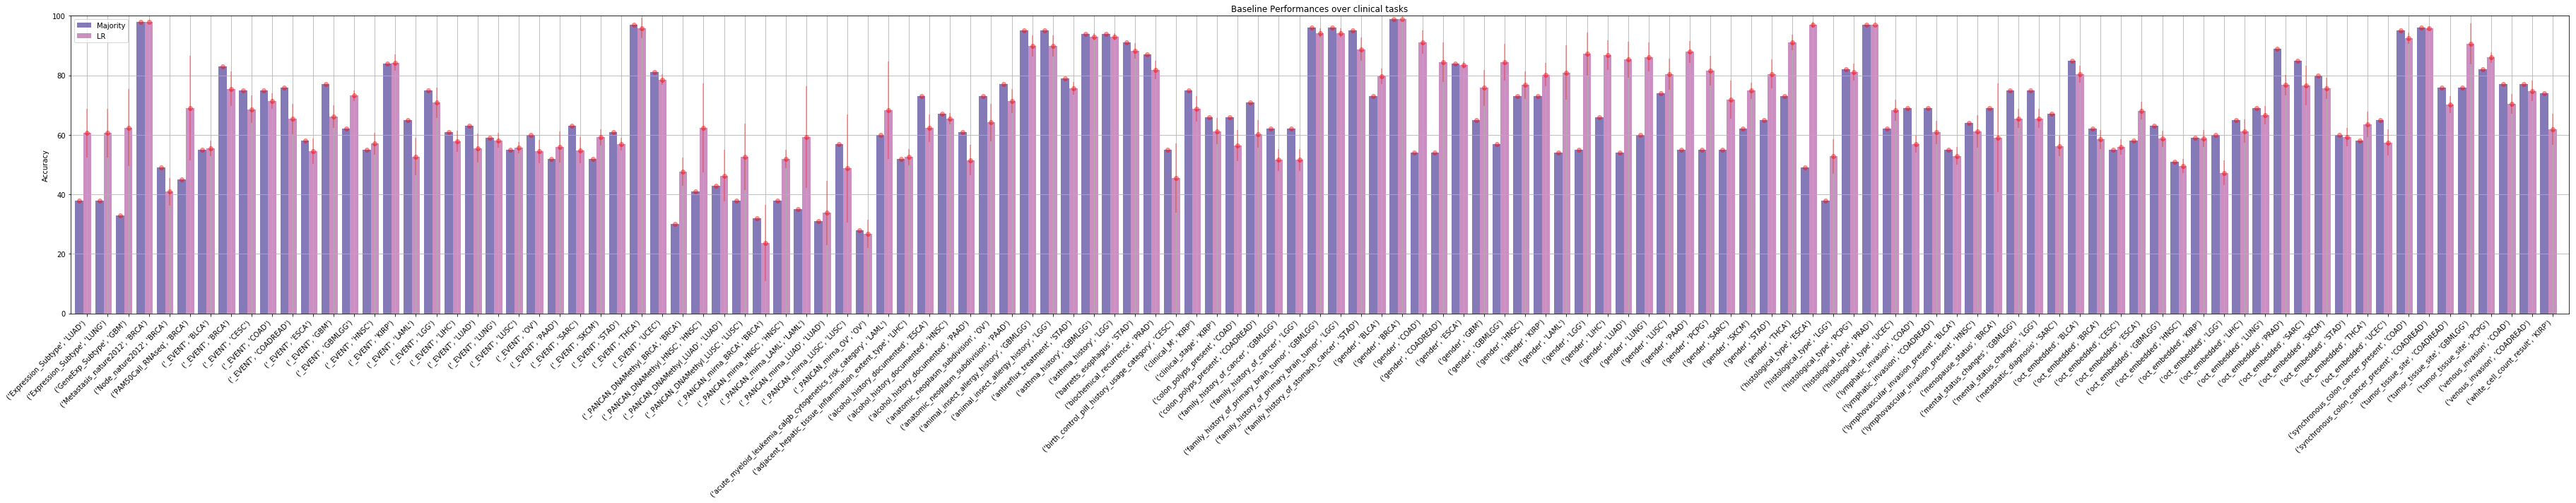

In [328]:
all_visualization(Maj_dict,LR_dict)

In [378]:
def all_visualization(Ma_dic, LR_dic, MLP_dic):
    
    Mlp_means, Mlp_std = [], []
    LR_means, LR_std = [], []
    Maj_means, Maj_std = [], []
    tasks = LR_dic.keys()
    for task in tasks:
        Maj_means.append(Ma_dic[task]['mean'])
        Maj_std.append(Ma_dic[task]['std'])
        LR_means.append(LR_dic[task]['mean'])
        LR_std.append(LR_dic[task]['std'])
        Mlp_means.append(MLP_dic[task]['mean'])
        Mlp_std.append(MLP_dic[task]['std'])
    
    x = np.arange(len(tasks))
    new_x = [1.5*i for i in x]
    fig, ax = plt.subplots(figsize=(50, 10))
    width = 0.4
    colors = ['#332288', '#AA4499', '#44AA99']
    ax.bar([p - width for p in new_x],
            Maj_means,
            width,
            alpha=0.6,
            color='#332288',
            label='Majority')
    ax.bar(new_x,
            LR_means,
            width,
            alpha=0.6,
            color='#AA4499',
            label='LR')
    ax.bar([p + width for p in new_x],
            Mlp_means,
            width,
            alpha=0.6,
            color='#44AA99',
            label='MLP')
    
    ax.set_ylabel('Accuracy')
    ax.set_title('Baseline Performances over clinical tasks')
    ax.set_xticks([p  for p in new_x])
    ax.set_xticklabels(tasks, rotation=45, ha="right")
    fig.tight_layout()

    plt.legend(['Majority', 'LR', 'MLP'], loc='upper left')
    plt.grid()
    
    # Error bars
    x_e, y_e, e = [], [], []
    for i in new_x:
        x_e.append([i-width, i, i+width])

    for i, task in enumerate(tasks):
        y_e.append([Maj_means[i], LR_means[i], Mlp_means[i]])

    for i, task in enumerate(tasks):
        e.append([Maj_std[i], LR_std[i], Mlp_std[i]])

    flatten_x = [item for sublist in x_e for item in sublist]
    flatten_y = [item for sublist in y_e for item in sublist]
    flatten_e = [item for sublist in e for item in sublist]


    plt.xlim(min(x) - 2 * width, max(x) + width * 2)
    plt.ylim(0, 100)

    plt.errorbar(flatten_x, flatten_y, flatten_e, linestyle='None', marker='o', color='r', alpha=0.4)
    plt.savefig(path + '/new_result_plot_with_error_bars.png')
    plt.show()

In [305]:
collections.Counter(y_train)

Counter({1: 17, 2: 6, 3: 3, 0: 24})

# MLP

In [346]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, seed, input_size, num_classes, num_layers, channels, learning_rate, batch_size, epochs, patience, weight_decay):
        super(MultiLayerPerceptron, self).__init__()
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.weight_decay = weight_decay
        self.num_layers = num_layers
        self.channels = channels
        self.output_size = num_classes
        random.seed(seed)
        torch.manual_seed(seed)
        
        nodes = []
        nodes += channels
        architecture = OrderedDict()
        for i in range(self.num_layers):
            architecture['fc' + str(i)] = nn.Linear(input_size, nodes[i])
            architecture['relu' + str(i)] = torch.nn.ReLU()
            input_size = nodes[i]

        self.features = nn.Sequential(architecture)

        self.classifier = nn.Linear(input_size, num_classes)
    
    @property
    def criterion(self):
        criterion = F.cross_entropy
        return criterion
    
    @property
    def optimizer(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimizer

    def forward(self, x):
        x = x.view(-1, self.input_size)
        features = self.features(x)
        logits = self.classifier(features)
        return logits

In [339]:
for taskid in sorted(tasks.task_ids):
    print(taskid)
    task = meta_dataloader.TCGA.TCGATask(taskid)
    print(task.id)

('Expression_Subtype', 'LUAD')
('Expression_Subtype', 'LUAD')
('Expression_Subtype', 'LUNG')
('Expression_Subtype', 'LUNG')
('GeneExp_Subtype', 'GBM')
('GeneExp_Subtype', 'GBM')
('Metastasis_nature2012', 'BRCA')
('Metastasis_nature2012', 'BRCA')
('Node_nature2012', 'BRCA')
('Node_nature2012', 'BRCA')
('PAM50Call_RNAseq', 'BRCA')
('PAM50Call_RNAseq', 'BRCA')
('_EVENT', 'ACC')
('_EVENT', 'ACC')
('_EVENT', 'BLCA')
('_EVENT', 'BLCA')
('_EVENT', 'BRCA')
('_EVENT', 'BRCA')
('_EVENT', 'CESC')
('_EVENT', 'CESC')
('_EVENT', 'CHOL')
('_EVENT', 'CHOL')
('_EVENT', 'COAD')
('_EVENT', 'COAD')
('_EVENT', 'COADREAD')
('_EVENT', 'COADREAD')
('_EVENT', 'ESCA')
('_EVENT', 'ESCA')
('_EVENT', 'GBM')
('_EVENT', 'GBM')
('_EVENT', 'GBMLGG')
('_EVENT', 'GBMLGG')
('_EVENT', 'HNSC')
('_EVENT', 'HNSC')
('_EVENT', 'KICH')
('_EVENT', 'KICH')
('_EVENT', 'KIRP')
('_EVENT', 'KIRP')
('_EVENT', 'LAML')
('_EVENT', 'LAML')
('_EVENT', 'LGG')


KeyboardInterrupt: 

In [353]:
#After hyperparameter search (in another notebook)
epochs = 250
patience = 10
batch_size = 32
lr= 0.0001 # best_lr
num_layer = 2 # best num_layer
channels = [128,64] # best channels
weight_decay = 0.0

In [357]:
avg_mlp_acc = {}

for taskid in sorted(tasks.task_ids):
    task = meta_dataloader.TCGA.TCGATask(taskid)
    input_size = task._samples.shape[1]
    num_classes = len(collections.Counter(task._labels))
    try:
        train_set, test_set = load_sets(task, valid = False)
        for seed in range(0,10):
            MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
            trained_model, train_loss = train(MLP_model, train_set, taskid, False)
            mlp_result = test(trained_model, test_set)
            print("\n {} MLP Accuracy is: {}" .format(taskid, mlp_result))
            if task.id in avg_mlp_acc.keys():
                avg_mlp_acc[task.id].append(mlp_result)
            else:
                avg_mlp_acc[task.id] = [mlp_result]
    except:
        print("Not enough number of samples")


 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 67.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 68.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 71.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 66.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 67.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 70.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 69.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 69.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 66.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 69.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 67.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 68.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 71.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 66.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 67.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 70.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 69.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 69.0

 ('Expres


 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 75.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 63.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 65.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 63.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 63.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 63.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 62.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 63.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 62.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 61.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 59.0

 ('_EVENT', 'LUAD') MLP Accuracy is: 52.0

 ('_EVENT', 'LUAD') MLP Accuracy is: 59.0

 ('_EVENT', 'LUAD') MLP Accuracy is: 56.99999999999999

 ('_EVE


 ('_PANCAN_DNAMethyl_LUSC', 'LUSC') MLP Accuracy is: 61.0
Not enough number of samples

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 38.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 39.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 38.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 39.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 43.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 43.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 42.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 43.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 42.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 43.0

 ('_PANCAN_mirna_HNSC', 'HNSC') MLP Accuracy is: 52.0

 ('_PANCAN_mirna_HNSC', 'HNSC') MLP Accuracy is: 54.0

 ('_PANCAN_mirna_HNSC', 'HNSC') MLP Accuracy is: 55.00000000000001

 ('_PANCAN_mirna_HNSC', 'HNSC') MLP Accuracy is: 54.0

 ('_PANCAN_mirna_HNSC', 'HNSC') MLP Accuracy is: 52.0

 ('_PANCAN_mirna_HNSC', 'HNSC') MLP Accuracy is: 53.0

 ('_PANCAN_mirna_H


 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 77.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 77.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 77.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 77.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 77.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 75.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy i


 ('family_history_of_cancer', 'GBMLGG') MLP Accuracy is: 52.0

 ('family_history_of_cancer', 'GBMLGG') MLP Accuracy is: 50.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 48.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 50.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 51.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 52.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 51.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 52.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 55.00000000000001

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 51.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 52.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 50.0
Not enough number of samples

 ('family_history_of_primary_brain_tumor', 'GBMLGG') MLP Accuracy is: 96.0

 ('family_history_of_primary_brain_tumor', 'GBMLGG') MLP Accuracy is: 96.0

 ('family_history_of_primary_brain_tumor', 'GBMLGG') MLP Accuracy is: 96.0

 ('


 ('gender', 'LIHC') MLP Accuracy is: 80.0

 ('gender', 'LIHC') MLP Accuracy is: 81.0

 ('gender', 'LIHC') MLP Accuracy is: 82.0

 ('gender', 'LUAD') MLP Accuracy is: 83.0

 ('gender', 'LUAD') MLP Accuracy is: 85.0

 ('gender', 'LUAD') MLP Accuracy is: 82.0

 ('gender', 'LUAD') MLP Accuracy is: 84.0

 ('gender', 'LUAD') MLP Accuracy is: 86.0

 ('gender', 'LUAD') MLP Accuracy is: 86.0

 ('gender', 'LUAD') MLP Accuracy is: 82.0

 ('gender', 'LUAD') MLP Accuracy is: 89.0

 ('gender', 'LUAD') MLP Accuracy is: 84.0

 ('gender', 'LUAD') MLP Accuracy is: 85.0

 ('gender', 'LUNG') MLP Accuracy is: 82.0

 ('gender', 'LUNG') MLP Accuracy is: 84.0

 ('gender', 'LUNG') MLP Accuracy is: 82.0

 ('gender', 'LUNG') MLP Accuracy is: 80.0

 ('gender', 'LUNG') MLP Accuracy is: 85.0

 ('gender', 'LUNG') MLP Accuracy is: 81.0

 ('gender', 'LUNG') MLP Accuracy is: 82.0

 ('gender', 'LUNG') MLP Accuracy is: 81.0

 ('gender', 'LUNG') MLP Accuracy is: 83.0

 ('gender', 'LUNG') MLP Accuracy is: 80.0

 ('gender'

Not enough number of samples
Not enough number of samples

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 52.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 53.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 52.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 53.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 52.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 54.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 52.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 53.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 52.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 54.0

 ('lymphovascular_invasion_present', 'HNSC') MLP Accuracy is: 60.0

 ('lymphovascular_invasion_present', 'HNSC') MLP Accuracy is: 64.0

 ('lymphovascular_invasion_present', 'HNSC') MLP Accuracy is: 61.0

 ('lymphovascular_invasion_present', 'HNSC') MLP Accuracy


 ('oct_embedded', 'LIHC') MLP Accuracy is: 68.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 67.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 66.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 66.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 66.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 67.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 66.0
Not enough number of samples

 ('oct_embedded', 'LUNG') MLP Accuracy is: 69.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 68.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 69.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 66.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 69.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 69.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 69.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 70.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 69.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 68.0
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples

 ('oct_embedded', 'PR


 ('venous_invasion', 'COADREAD') MLP Accuracy is: 77.0
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 72.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 73.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 73.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0


In [358]:
print(avg_mlp_acc)

{('Expression_Subtype', 'LUAD'): [67.0, 68.0, 71.0, 66.0, 67.0, 70.0, 69.0, 69.0, 66.0, 69.0], ('Expression_Subtype', 'LUNG'): [67.0, 68.0, 71.0, 66.0, 67.0, 70.0, 69.0, 69.0, 66.0, 69.0], ('GeneExp_Subtype', 'GBM'): [75.0, 71.0, 71.0, 74.0, 74.0, 72.0, 73.0, 74.0, 75.0, 74.0], ('Metastasis_nature2012', 'BRCA'): [98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0], ('Node_nature2012', 'BRCA'): [45.0, 47.0, 47.0, 52.0, 45.0, 48.0, 47.0, 49.0, 44.0, 51.0], ('PAM50Call_RNAseq', 'BRCA'): [82.0, 80.0, 83.0, 77.0, 83.0, 78.0, 82.0, 80.0, 83.0, 82.0], ('_EVENT', 'BLCA'): [56.00000000000001, 60.0, 56.99999999999999, 60.0, 60.0, 59.0, 57.99999999999999, 61.0, 57.99999999999999, 56.99999999999999], ('_EVENT', 'BRCA'): [82.0, 82.0, 82.0, 82.0, 84.0, 82.0, 84.0, 84.0, 84.0, 83.0], ('_EVENT', 'CESC'): [70.0, 66.0, 68.0, 68.0, 69.0, 69.0, 68.0, 70.0, 69.0, 69.0], ('_EVENT', 'COAD'): [75.0, 76.0, 76.0, 76.0, 76.0, 76.0, 76.0, 74.0, 76.0, 76.0], ('_EVENT', 'COADREAD'): [72.0, 73.0, 73.0, 74.0,

In [359]:
MLP_dict = measure_mean_std(avg_mlp_acc)

In [360]:
import os
path = '/Users/mandanasamiei/PycharmProjects/TCGA_Benchmark'
result_dataframe = pd.DataFrame.from_dict(Maj_dict, orient='index')
result_dataframe.to_csv(os.path.join(path,'MLP_result_10seeds.csv'))

In [361]:
print(MLP_dict)
print(len(MLP_dict))#121

{('Expression_Subtype', 'LUAD'): {'mean': 68.2, 'std': 1.5999999999999999}, ('Expression_Subtype', 'LUNG'): {'mean': 68.2, 'std': 1.5999999999999999}, ('GeneExp_Subtype', 'GBM'): {'mean': 73.3, 'std': 1.4177446878757824}, ('Metastasis_nature2012', 'BRCA'): {'mean': 98.0, 'std': 0.0}, ('Node_nature2012', 'BRCA'): {'mean': 47.5, 'std': 2.4596747752497685}, ('PAM50Call_RNAseq', 'BRCA'): {'mean': 81.0, 'std': 2.04939015319192}, ('_EVENT', 'BLCA'): {'mean': 58.6, 'std': 1.5620499351813317}, ('_EVENT', 'BRCA'): {'mean': 82.9, 'std': 0.9433981132056604}, ('_EVENT', 'CESC'): {'mean': 68.6, 'std': 1.1135528725660042}, ('_EVENT', 'COAD'): {'mean': 75.7, 'std': 0.6403124237432849}, ('_EVENT', 'COADREAD'): {'mean': 72.4, 'std': 0.9165151389911681}, ('_EVENT', 'ESCA'): {'mean': 52.4, 'std': 0.9165151389911679}, ('_EVENT', 'GBM'): {'mean': 73.9, 'std': 0.7000000000000001}, ('_EVENT', 'GBMLGG'): {'mean': 74.1, 'std': 0.30000000000000004}, ('_EVENT', 'HNSC'): {'mean': 60.1, 'std': 1.3000000000000012},

[68.2, 68.2, 73.3, 98.0, 47.5, 81.0, 58.6, 82.9, 68.6, 75.7, 72.4, 52.4, 73.9, 74.1, 60.1, 85.9, 60.2, 75.9, 62.4, 57.5, 62.0, 58.1, 58.2, 58.0, 56.5, 61.4, 57.9, 97.0, 79.9, 52.3, 75.0, 52.4, 61.0, 41.0, 53.6, 72.6, 39.9, 61.5, 30.9, 79.3, 56.3, 68.4, 65.1, 55.6, 73.0, 76.7, 95.0, 95.0, 76.5, 94.0, 94.0, 91.0, 86.6, 56.7, 72.5, 64.8, 60.6, 69.1, 51.2, 51.2, 96.0, 96.0, 94.0, 77.9, 99.0, 86.8, 78.6, 84.0, 70.8, 79.7, 75.8, 80.7, 54.2, 73.5, 81.3, 84.6, 82.0, 75.1, 82.1, 74.4, 71.5, 68.3, 77.6, 82.3, 97.6, 54.2, 84.0, 97.0, 71.4, 61.8, 66.2, 52.7, 61.9, 69.0, 68.1, 68.1, 58.7, 84.0, 56.5, 53.2, 70.0, 61.6, 44.6, 56.5, 45.1, 66.6, 68.6, 79.7, 80.5, 79.4, 66.5, 66.4, 58.9, 95.0, 96.0, 75.8, 96.0, 89.7, 77.0, 77.4, 73.6]


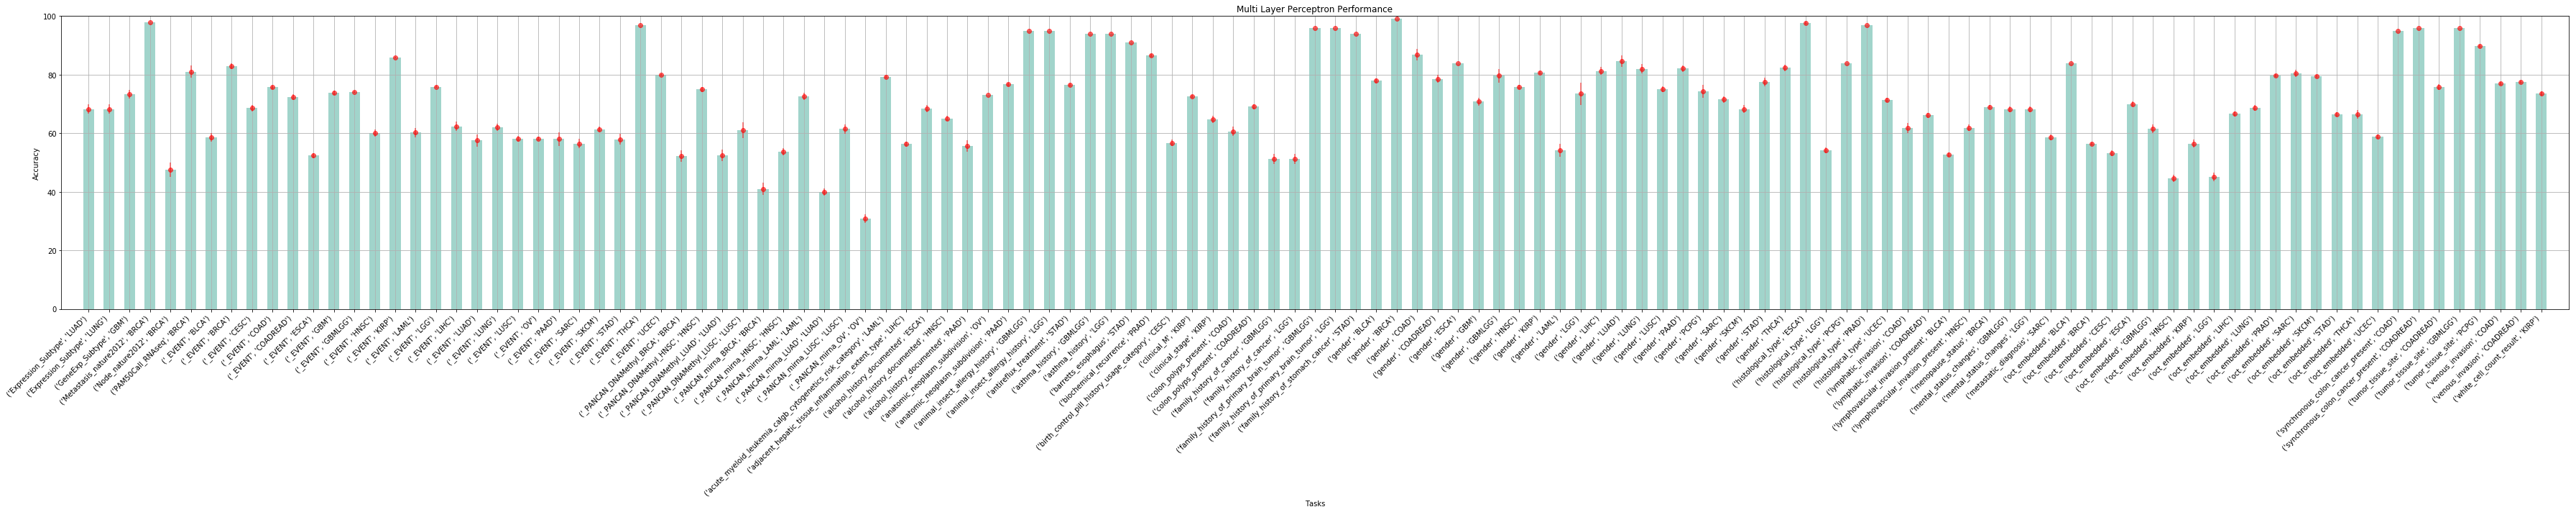

In [364]:
model_visualization(MLP_dict, list(MLP_dict.keys()), "Multi Layer Perceptron", '#44AA99')

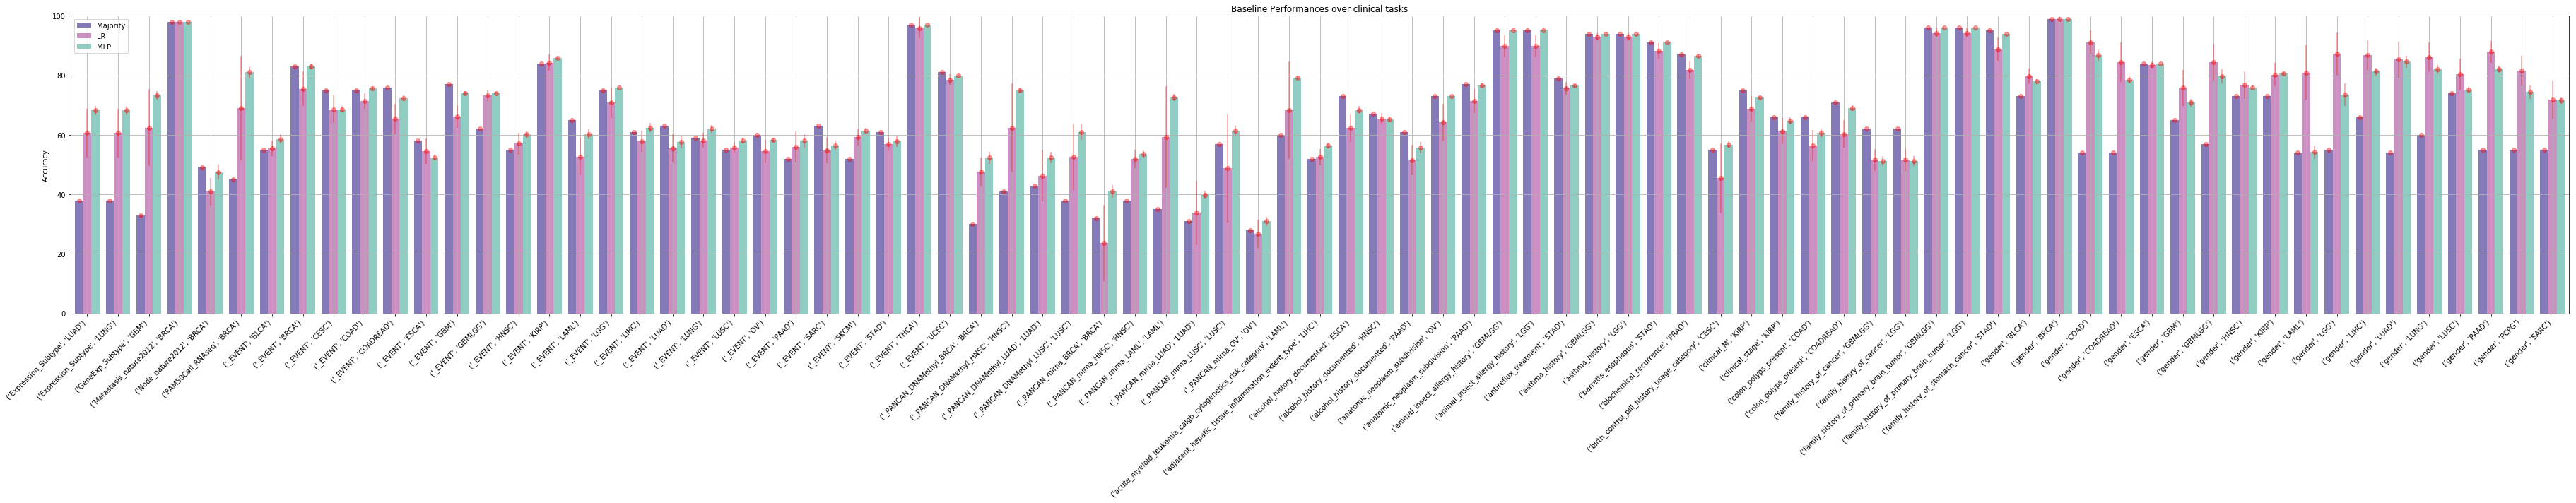

In [379]:
all_visualization(Maj_dict, LR_dict, MLP_dict)

In [380]:
print(MLP_dict)

{('Expression_Subtype', 'LUAD'): {'mean': 68.2, 'std': 1.5999999999999999}, ('Expression_Subtype', 'LUNG'): {'mean': 68.2, 'std': 1.5999999999999999}, ('GeneExp_Subtype', 'GBM'): {'mean': 73.3, 'std': 1.4177446878757824}, ('Metastasis_nature2012', 'BRCA'): {'mean': 98.0, 'std': 0.0}, ('Node_nature2012', 'BRCA'): {'mean': 47.5, 'std': 2.4596747752497685}, ('PAM50Call_RNAseq', 'BRCA'): {'mean': 81.0, 'std': 2.04939015319192}, ('_EVENT', 'BLCA'): {'mean': 58.6, 'std': 1.5620499351813317}, ('_EVENT', 'BRCA'): {'mean': 82.9, 'std': 0.9433981132056604}, ('_EVENT', 'CESC'): {'mean': 68.6, 'std': 1.1135528725660042}, ('_EVENT', 'COAD'): {'mean': 75.7, 'std': 0.6403124237432849}, ('_EVENT', 'COADREAD'): {'mean': 72.4, 'std': 0.9165151389911681}, ('_EVENT', 'ESCA'): {'mean': 52.4, 'std': 0.9165151389911679}, ('_EVENT', 'GBM'): {'mean': 73.9, 'std': 0.7000000000000001}, ('_EVENT', 'GBMLGG'): {'mean': 74.1, 'std': 0.30000000000000004}, ('_EVENT', 'HNSC'): {'mean': 60.1, 'std': 1.3000000000000012},

# Model Comparison

In [383]:
mean_mean = []
mean_std = []

Mlp_means, Mlp_std = [], []
LR_means, LR_std = [], []
Maj_means, Maj_std = [], []
tasks = Maj_dict.keys()

for task in tasks:
    Maj_means.append(Maj_dict[task]['mean'])
    Maj_std.append(Maj_dict[task]['std'])
    LR_means.append(LR_dict[task]['mean'])
    LR_std.append(LR_dict[task]['std'])
    Mlp_means.append(MLP_dict[task]['mean'])
    Mlp_std.append(MLP_dict[task]['std'])

mean_mean.append(np.mean(Maj_means))
mean_mean.append(np.mean(LR_means))
mean_mean.append(np.mean(Mlp_means))

mean_std.append(np.std(Maj_means))
mean_std.append(np.std(LR_means))
mean_std.append(np.std(Mlp_means))

print(mean_mean)
print(mean_std)

[66.18181818181819, 68.78512396694214, 71.19090909090909]
[16.879739922010373, 15.918857150475835, 14.624783674320149]


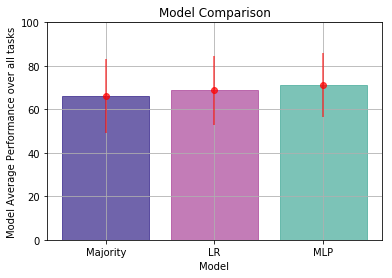

In [394]:
barlist=plt.bar([1,2,3], mean_mean, alpha=0.7)
barlist[0].set_color('#332288')
barlist[1].set_color('#AA4499')
barlist[2].set_color('#44AA99')
plt.xticks([1, 2, 3], ['Majority','LR','MLP'])
plt.title("Model Comparison")
plt.ylabel('Model Average Performance over all tasks')
plt.xlabel('Model')
plt.ylim(0,100)
plt.errorbar([1,2,3], mean_mean, mean_std, linestyle='None', marker='o', color='r', alpha=0.7)
plt.grid()
plt.show()